In [9]:
import sys
print(sys.version)

3.6.2 (default, Jul 17 2017, 16:44:45) 
[GCC 4.2.1 Compatible Apple LLVM 8.1.0 (clang-802.0.42)]


In [81]:
import logging
import json
from collections import Counter, defaultdict
from math import log
from functools import lru_cache

from bs4 import BeautifulSoup
import requests
import regex as re
import networkx as nx

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

In [24]:
logging.basicConfig()
LOG = logging.getLogger()

RFC_RANGE = (1, 8229 + 1)

# Helper functions

In [21]:
def url_from_rfc(rfc):
    return 'https://tools.ietf.org/html/rfc{}'.format(rfc)

In [62]:
def soup_from_rfc(source_rfc):
    url = url_from_rfc(source_rfc)
    resp = requests.get(url)
    resp.raise_for_status()
    return BeautifulSoup(resp.content, 'html.parser')

In [86]:
@lru_cache(maxsize=None)
def title_from_soup(source_rfc, soup=None):
    """
    Return the title of an RFC's soup.
    
    This assumes that the title resides in the first span.
    """
    if soup is None:
        soup = soup_from_rfc(source_rfc)
    try:
        return soup.find_all('span', attrs={'class':'h1'})[0].text
    except IndexError:
        LOG.warning(f'RFC {source_rfc}: title error')
        return ''

In [83]:
soup = soup_from_rfc(2119)
title_from_soup(2119, soup=soup)

'Key words for use in RFCs to Indicate Requirement Levels'

In [16]:
def outgoing(soup, source_rfc):
    """Yield all non-self RFC links."""
    seen = {source_rfc}
    for link in soup.findAll('a', href=True):
        match = re.search('^\./rfc(\d+)', link['href'])
        if match is not None:
            rfc = int(match.group(1))
            seen.add(rfc)
    return sorted(seen - {source_rfc})

In [17]:
soup = soup_from_rfc(8195)
outgoing(soup, 8195)

[1997, 1998, 4264, 7454, 7841, 7947, 7948, 8092]

In [77]:
print(url_from_rfc(8195))

https://tools.ietf.org/html/rfc8195


# Generate the data

In [6]:
raise

RuntimeError: No active exception to reraise

In [10]:
%%time

data = {}
missing_rfcs = []

for rfc in range(*RFC_RANGE):
    out = []
    try:
        soup = soup_from_rfc(rfc)
        out = outgoing(soup, rfc)
    except requests.HTTPError as e:
        LOG.warning(f'RFC {rfc}: {e}')
        missing_rfcs.append(rfc)
    data[rfc] = out

CPU times: user 7min 3s, sys: 12.3 s, total: 7min 16s
Wall time: 1h 34min 7s


In [ ]:
with open('missing_rfcs.txt', 'w') as f:
    for rfc in sorted(missing_rfcs):
        f.write(f'{rfc}\n')

# [Reload]

In [7]:
ls *.txt *.json

miserables.json   missing-rfcs.txt  pruned.json       rfc-data.json     test.json


In [27]:
with open('missing-rfcs.txt') as f:
    missing_rfcs = [line.strip() for line in f if line.strip()]

In [68]:
with open('rfc-data.json') as f:
    data = json.load(f)
    # BECAUSE PYTHON JSON CANT HANDLE INTEGER KEYS!?!
    d = {}
    for k, v in data.items():
        d[int(k)] = v
    data = d
    del d

# ¡Explore!

What proportion of RFCs are missing?

In [29]:
len(missing_rfcs), float(len(missing_rfcs))/(RFC_RANGE[1] - 1)

(123, 0.014947138169886985)

Are there any RFCs in the outgoing set that doesn't make sense?

In [30]:
for rfc, out in data.items():
    pruned = [o for o in out if RFC_RANGE[0] <= o <= RFC_RANGE[1]]
    if len(pruned) < len(out):
        print(rfc, sorted(set(out) - set(pruned)))

661 [65125]
1012 [8401]
2626 [10336]
3426 [25434]
4523 [44520]
7991 [9999]
7992 [9999]


There's very few here, such that we're not going to worry about it.

Let's look at some degree distributions!

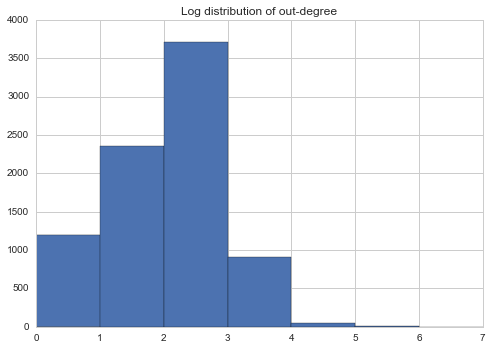

In [41]:
with sns.axes_style('whitegrid'):
    plt.hist([log(len(out) + 1) for out in data.values()], bins=range(8))
    plt.title('Log distribution of out-degree')
    plt.show()

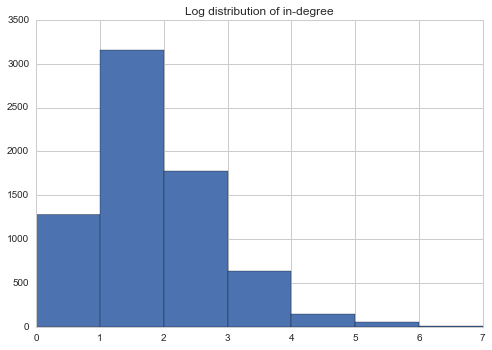

In [40]:
with sns.axes_style('whitegrid'):
    inv = defaultdict(list)
    for rfc, out in data.items():
        for o in out:
            inv[o].append(rfc)
    plt.hist([log(len(v) + 1) for v in inv.values()], bins=range(8))
    plt.title('Log distribution of in-degree')
    plt.show()

How many RFCs link to missing RFCs?

In [52]:
missing = Counter()
for rfc, out in data.items():
    missing.update(o for o in out if o in missing_rfcs)
missing.most_common()

[]

Woah. I almost don't believe that!

Which RFCs are the most central?

In [196]:
graph = nx.Graph()

for rfc, out in data.items():
    for o in out:
        graph.add_edge(rfc, o)
    graph.add_node(rfc)  # in the case that RFC is an island

In [178]:
def print_scores(scores):
    for score, rfc in scores:
        title = title_from_soup(rfc)
        url = url_from_rfc(rfc)
        print('{:.3f}{:>6}{:>64}  {:<32}'.format(score, rfc, title, url))

In [192]:
def most_important(important, graph, n=8):
    centers = sorted((score, rfc) for rfc, score in important(graph).items())
    print_scores(reversed(centers[-n:]))
    return centers

In [193]:
deg_top = most_important(nx.degree_centrality, graph)

0.491  2119        Key words for use in RFCs to Indicate Requirement Levels  https://tools.ietf.org/html/rfc2119
0.261  5741                          RFC Streams, Headers, and Boilerplates  https://tools.ietf.org/html/rfc5741
0.112  1012              BIBLIOGRAPHY OF REQUEST FOR COMMENTS 1 THROUGH 999  https://tools.ietf.org/html/rfc1012
0.072  5226   Guidelines for Writing an IANA Considerations Section in RFCs  https://tools.ietf.org/html/rfc5226
0.062  3261                                SIP: Session Initiation Protocol  https://tools.ietf.org/html/rfc3261
0.055   791                                                                  https://tools.ietf.org/html/rfc791
0.054   822                                      STANDARD FOR THE FORMAT OF  https://tools.ietf.org/html/rfc822
0.050   793                                                                  https://tools.ietf.org/html/rfc793


In [194]:
eig_top = most_important(nx.eigenvector_centrality, graph)

0.523  2119        Key words for use in RFCs to Indicate Requirement Levels  https://tools.ietf.org/html/rfc2119
0.273  5741                          RFC Streams, Headers, and Boilerplates  https://tools.ietf.org/html/rfc5741
0.095  5226   Guidelines for Writing an IANA Considerations Section in RFCs  https://tools.ietf.org/html/rfc5226
0.072  3261                                SIP: Session Initiation Protocol  https://tools.ietf.org/html/rfc3261
0.060  5246                     The Transport Layer Security (TLS) Protocol  https://tools.ietf.org/html/rfc5246
0.053  2434   Guidelines for Writing an IANA Considerations Section in RFCs  https://tools.ietf.org/html/rfc2434
0.053  5234                   Augmented BNF for Syntax Specifications: ABNF  https://tools.ietf.org/html/rfc5234
0.052  3986               Uniform Resource Identifier (URI): Generic Syntax  https://tools.ietf.org/html/rfc3986


In [195]:
combo_top = defaultdict(lambda: 1)
for top in [deg_top, eig_top]:
    for score, rfc in top:
        combo_top[rfc] *= score
        
combo_top = sorted({v: k for k, v in combo_top.items()}.items())
print_scores(reversed(combo_top[-16:]))

0.257  2119        Key words for use in RFCs to Indicate Requirement Levels  https://tools.ietf.org/html/rfc2119
0.071  5741                          RFC Streams, Headers, and Boilerplates  https://tools.ietf.org/html/rfc5741
0.007  5226   Guidelines for Writing an IANA Considerations Section in RFCs  https://tools.ietf.org/html/rfc5226
0.004  3261                                SIP: Session Initiation Protocol  https://tools.ietf.org/html/rfc3261
0.003   791                                                                  https://tools.ietf.org/html/rfc791
0.002   793                                                                  https://tools.ietf.org/html/rfc793
0.002  5246                     The Transport Layer Security (TLS) Protocol  https://tools.ietf.org/html/rfc5246
0.002  2434   Guidelines for Writing an IANA Considerations Section in RFCs  https://tools.ietf.org/html/rfc2434
0.002  3986               Uniform Resource Identifier (URI): Generic Syntax  https://tools.ietf.or

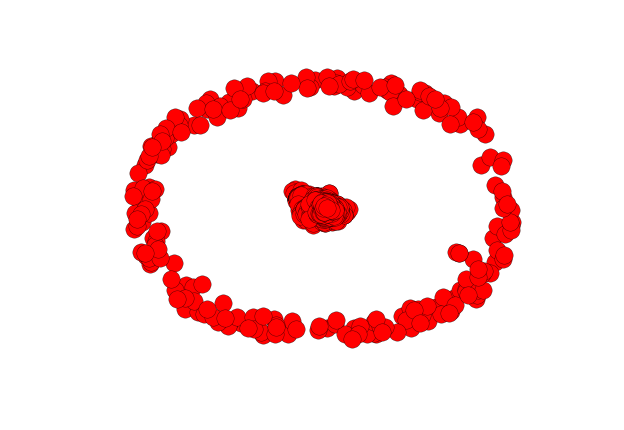

In [205]:
nx.draw_spring(graph)